In [10]:
import numpy as np
import pickle
import networkx as nx
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 8)

In [5]:
path = "routes_master_data.csv"
df = pd.read_csv(path)
df

,Route_ID,Route_Name,Direction,Private_Code,Point_ID,Order,RoutePointRef,StopPlace ID,StopPlace Name,StopPlace Private Code,...,Quay Longitude,Journey_ID,TransportMode,OperatorRef,DayTypeRef,PublicCode,PrivateCode,StopPointInJourneyPatternRef,ArrivalTime,DepartureTime
0,14010000668408490,Vigelsjö,outbound,657,14010000668408495,1,9022001064146002,9021001064146000,Campus Roslagen,64146,...,18.685736,1.401000e+16,bus,9.013001e+15,62vdge1e16h1c23r2ie5akj4600d2l3r,NaN,657.0,1.401000e+16,NaN,06:09:00
1,14010000668408490,Vigelsjö,outbound,657,14010000668408495,1,9022001064146002,9021001064146000,Campus Roslagen,64146,...,18.685736,1.401000e+16,bus,9.013001e+15,62vdge1e16h1c23r2ie5akj4600d2l3r,NaN,657.0,1.401000e+16,NaN,07:08:00
2,14010000668408490,Vigelsjö,outbound,657,14010000668408495,1,9022001064146002,9021001064146000,Campus Roslagen,64146,...,18.685736,1.401000e+16,bus,9.013001e+15,62vdge1e16h1c23r2ie5akj4600d2l3r,NaN,657.0,1.401000e+16,NaN,11:08:00
3,14010000668408490,Vigelsjö,outbound,657,14010000668408495,1,9022001064146002,9021001064146000,Campus Roslagen,64146,...,18.685736,1.401000e+16,bus,9.013001e+15,62vdge1e16h1c23r2ie5akj4600d2l3r,NaN,657.0,1.401000e+16,NaN,16:08:00
4,14010000668408490,Vigelsjö,outbound,657,14010000668408495,1,9022001064146002,9021001064146000,Campus Roslagen,64146,...,18.685736,1.401000e+16,bus,9.013001e+15,62vdge1e16h1c23r2ie5akj4600d2l3r,NaN,657.0,1.401000e+16,NaN,18:08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312327,14010000621141260,Vallentuna station,inbound,669,14010000621141284,20,9022001059500001,9021001059500000,Markim,59500,...,18.036867,1.401000e+16,bus,9.013001e+15,bncpagqso7dvr0jmc2o233d3een6g00p,NaN,669.0,1.401000e+16,09:23:00,09:23:00
1312328,14010000621141260,Vallentuna station,inbound,669,14010000621141285,21,9022001060157006,9021001060157000,Vallentuna station,60157,...,18.078910,1.401000e+16,bus,9.013001e+15,bncpagqso7dvr0jmc2o233d3een6g00p,NaN,669.0,1.401000e+16,19:48:00,NaN
1312329,14010000621141260,Vallentuna station,inbound,669,14010000621141285,21,9022001060157006,9021001060157000,Vallentuna station,60157,...,18.078910,1.401000e+16,bus,9.013001e+15,bncpagqso7dvr0jmc2o233d3een6g00p,NaN,669.0,1.401000e+16,12:12:00,NaN
1312330,14010000621141260,Vallentuna station,inbound,669,14010000621141285,21,9022001060157006,9021001060157000,Vallentuna station,60157,...,18.078910,1.401000e+16,bus,9.013001e+15,bncpagqso7dvr0jmc2o233d3een6g00p,NaN,669.0,1.401000e+16,14:21:00,NaN


In [11]:
for k in df.keys(): print(k)

Route_ID
Route_Name
Direction
Private_Code
Point_ID
Order
RoutePointRef
StopPlace ID
StopPlace Name
StopPlace Private Code
StopPlace Latitude
StopPlace Longitude
Quay ID
Quay Name
Quay Private Code
Quay Latitude
Quay Longitude
Journey_ID
TransportMode
OperatorRef
DayTypeRef
PublicCode
PrivateCode
StopPointInJourneyPatternRef
ArrivalTime
DepartureTime


# Constructing the route graph
This code does the following:

1. It creates a function `time_difference` to calculate the time difference between two time strings.

2. It initializes an empty graph `G` using NetworkX.

3. It adds nodes to the graph, using 'StopPlace ID' as the unique identifier and including name, latitude, and longitude as node attributes for both the bus stops and the quay stops.

4. It then iterates through each unique route, adding edges between consecutive stops on that route.

5. For each edge, it calculates the travel time (if departure and arrival times are available) and adds this as an edge attribute.

6. If an edge already exists (because two stops might be connected by multiple routes), it updates the travel time only if the new time is shorter.

7. It also adds the route_id and transport_mode as edge attributes.

8. Finally, it prints some basic information about the graph and examples of node and edge data.

This graph structure allows for various route planning algorithms to be applied. You can easily find paths between any two stops, calculate total travel times, or even consider factors like transport mode in your routing decisions.

In [12]:
def time_difference(time1, time2):
    """Calculate absolute time difference in minutes"""
    t1 = datetime.strptime(time1, "%H:%M:%S")
    t2 = datetime.strptime(time2, "%H:%M:%S")
    # Use abs() to ensure the result is always positive
    return abs((t2 - t1).total_seconds() / 60)

# Create an empty graph
G = nx.Graph()

# Add nodes (quays) to the graph
for _, row in tqdm(df.drop_duplicates(subset=['Quay ID']).iterrows(), desc="Adding nodes"):
    G.add_node(row['Quay ID'], 
               quay_name=row['Quay Name'],
               quay_latitude=row['Quay Latitude'],
               quay_longitude=row['Quay Longitude'],
               stop_place_id=row['StopPlace ID'],
               stop_place_name=row['StopPlace Name'])

# Add edges (connections between quays)
for route_id in tqdm(df['Route_ID'].unique(), desc="Adding edges"):
    route_df = df[df['Route_ID'] == route_id].sort_values('Order')
    
    for i in range(len(route_df) - 1):
        current_stop = route_df.iloc[i]
        next_stop = route_df.iloc[i+1]
        
        # Check if current_stop and next_stop are different
        if current_stop['Quay ID'] != next_stop['Quay ID']:
            # Calculate travel time
            if pd.notnull(current_stop['DepartureTime']) and pd.notnull(next_stop['ArrivalTime']):
                travel_time = time_difference(current_stop['DepartureTime'], next_stop['ArrivalTime'])
            else:
                travel_time = np.infty
            
            # Add edge if it doesn't exist, or update if the new travel time is shorter
            if G.has_edge(current_stop['Quay ID'], next_stop['Quay ID']):
                existing_time = G[current_stop['Quay ID']][next_stop['Quay ID']]['travel_time']
                if travel_time is not None and (existing_time is None or travel_time < existing_time):
                    G[current_stop['Quay ID']][next_stop['Quay ID']]['travel_time'] = travel_time
            else:
                G.add_edge(current_stop['Quay ID'], next_stop['Quay ID'], 
                           travel_time=travel_time,
                           route_id=route_id,
                           transport_mode=current_stop['TransportMode'])

# Print some basic information about the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Example of accessing node and edge data
print("\nExample Node Data:")
print(list(G.nodes(data=True))[0])

print("\nExample Edge Data:")
print(list(G.edges(data=True))[0])

# Check for self-loops
self_loops = list(nx.selfloop_edges(G))
print(f"\nNumber of self-loops: {len(self_loops)}")

# saving the graph
with open("graph.pickle", "wb") as f:
    pickle.dump(G, f)

Adding nodes: 11755it [00:00, 16803.01it/s]
Adding edges: 100%|██████████| 3150/3150 [02:43<00:00, 19.24it/s]


Number of nodes: 11755
Number of edges: 14646

Example Node Data:
(9022001064146002, {'quay_name': 'Campus Roslagen', 'quay_latitude': 59.748264, 'quay_longitude': 18.685736, 'stop_place_id': 9021001064146000, 'stop_place_name': 'Campus Roslagen'})

Example Edge Data:
(9022001064146002, 9022001062571002, {'travel_time': 0.6166666666666667, 'route_id': 14010000668408490, 'transport_mode': 'bus'})

Number of self-loops: 0


# Graph visualization

Drawing edges: 100%|██████████| 14646/14646 [03:48<00:00, 64.07it/s]


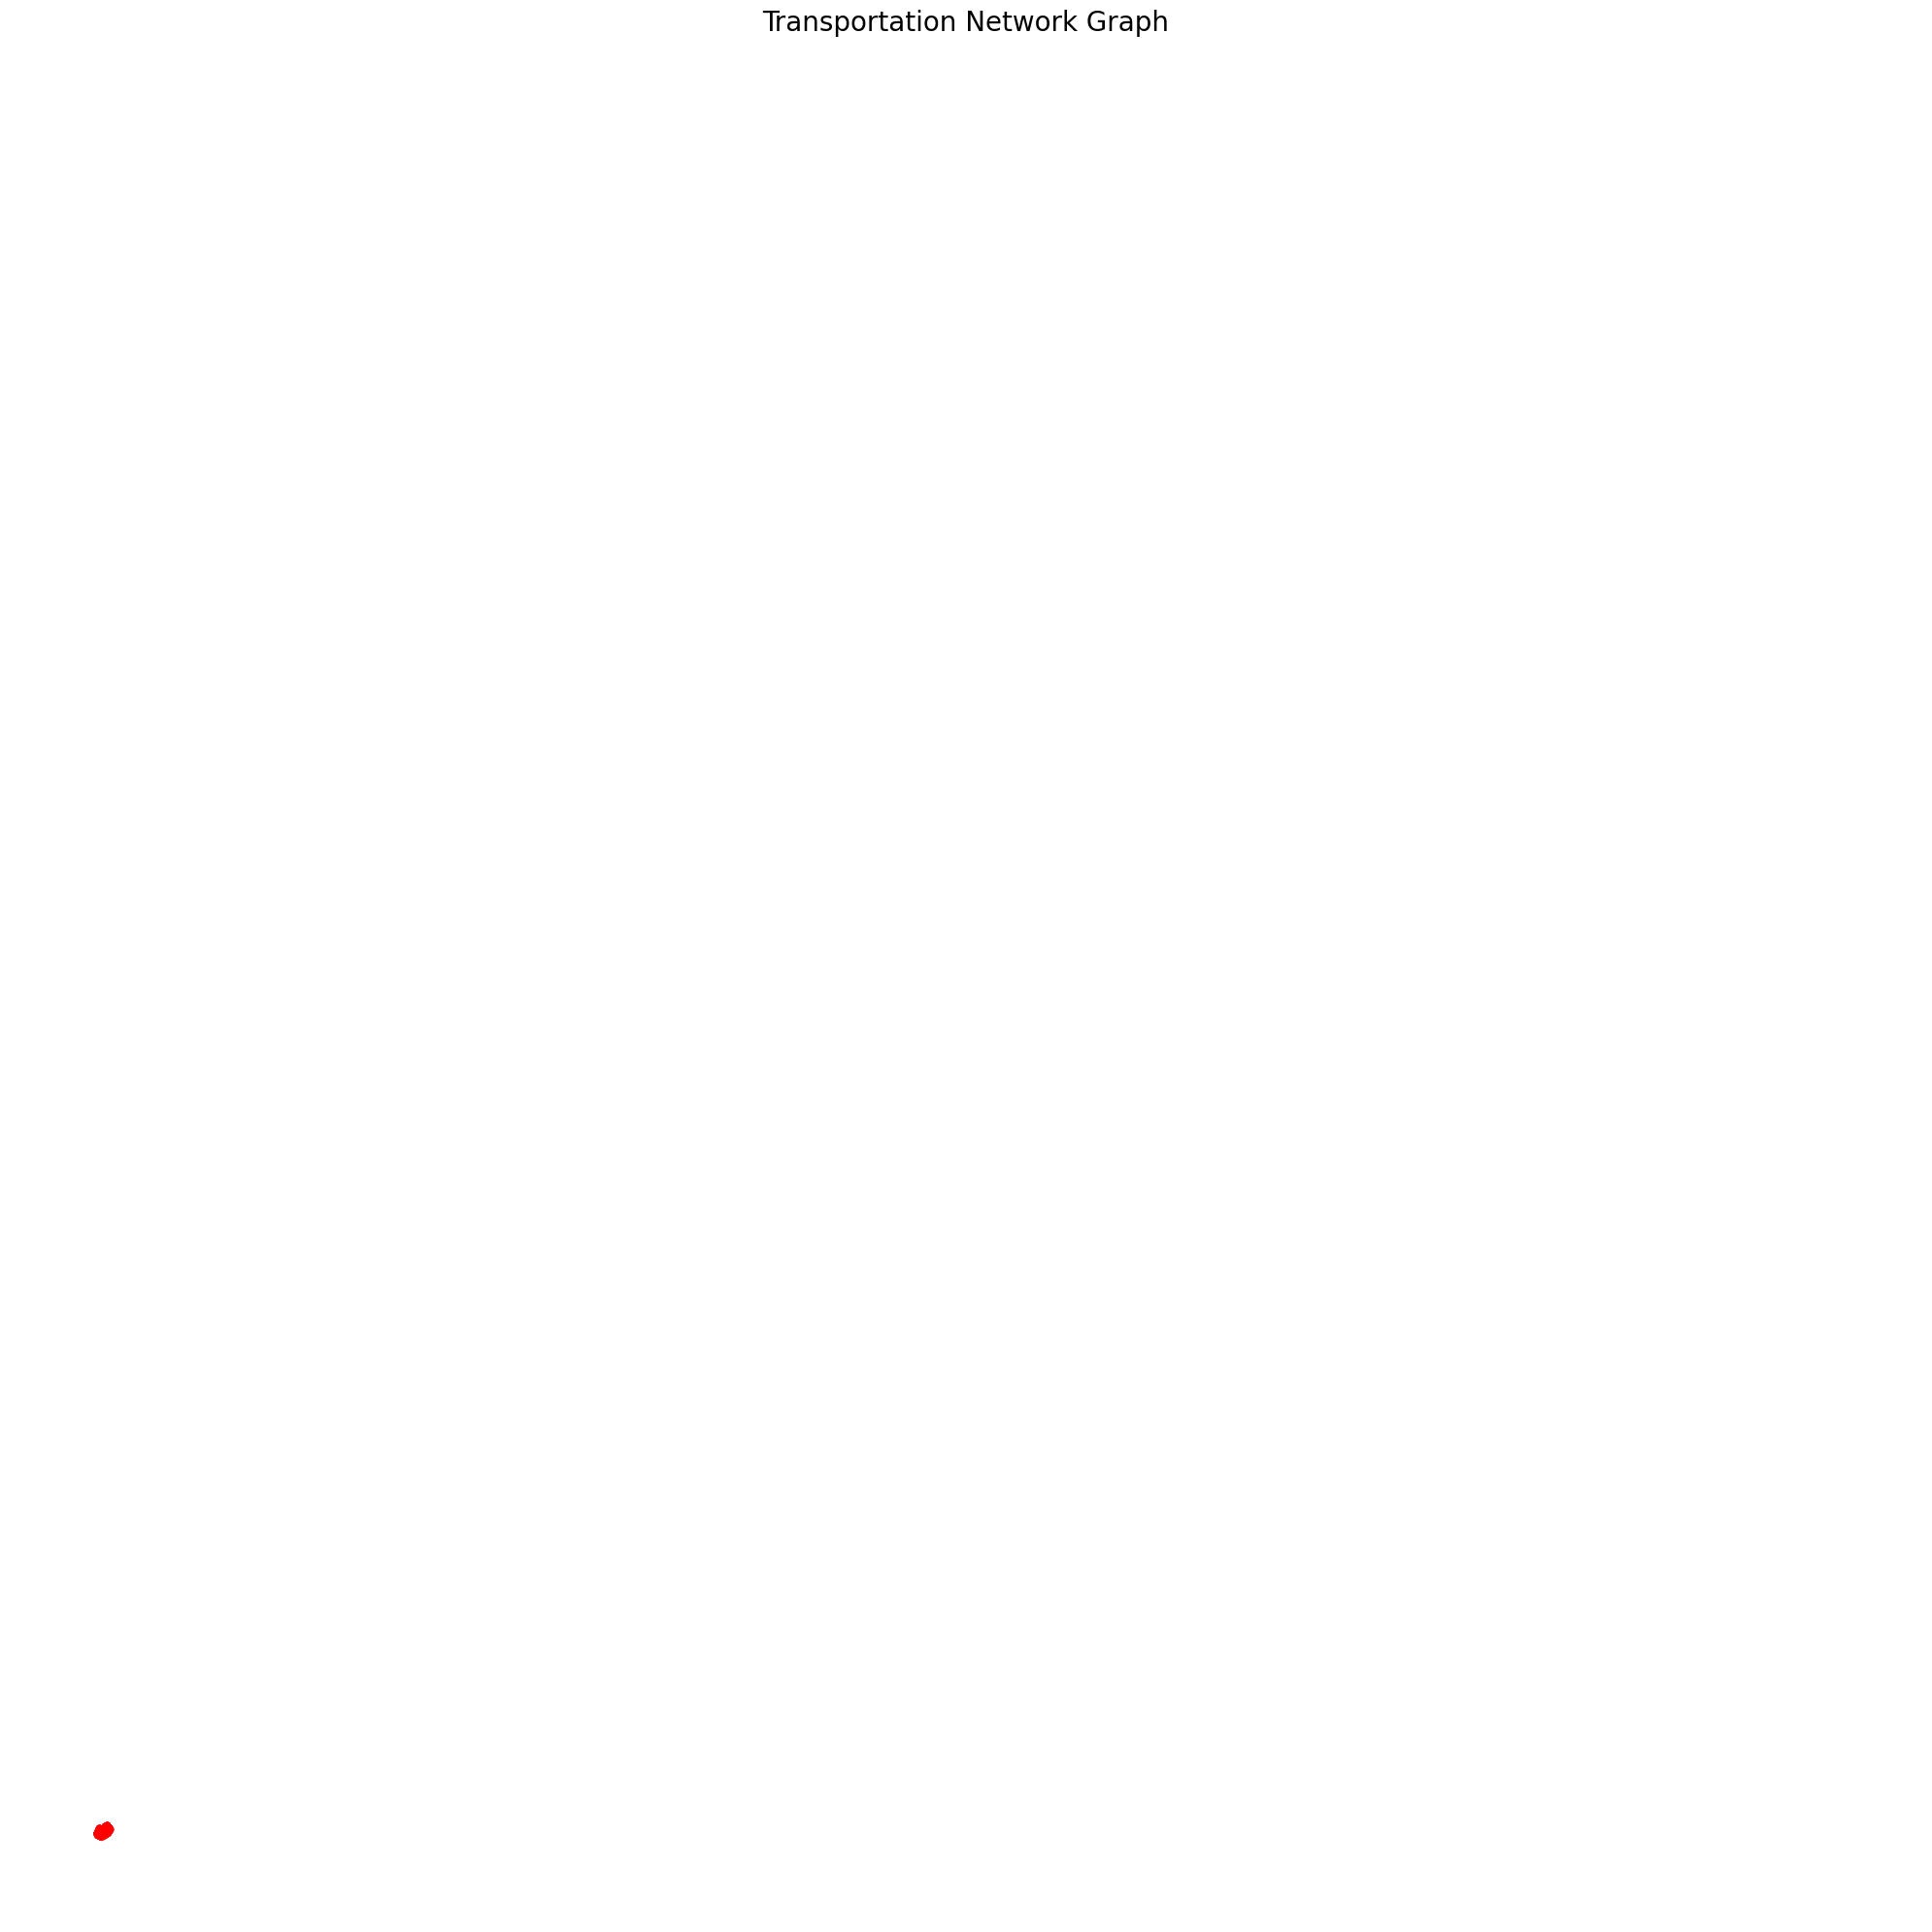

In [15]:
def visualize_graph(G, figsize=(20, 20), node_size=20, edge_width=0.5):
    # Create a new figure
    plt.figure(figsize=figsize)

    # Get position dictionary based on latitude and longitude
    pos = {node: (G.nodes[node]['quay_longitude'], G.nodes[node]['quay_latitude']) for node in G.nodes()}

    # Draw the edges
    for (u, v, data) in tqdm(G.edges(data=True), desc="Drawing edges"):
        # Normalize travel time and use it for edge color
        normalized_time = data['travel_time'] / max(d['travel_time'] for _, _, d in G.edges(data=True) if d['travel_time'] is not None)
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=edge_width, alpha=0.6, 
                               edge_color=plt.cm.viridis(normalized_time))

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='red', alpha=0.6)

    # Remove axis
    plt.axis('off')

    # Add a colorbar to show travel time scale
#    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=max(d['travel_time'] for _, _, d in G.edges(data=True) if d['travel_time'] is not None)))
#    sm.set_array([])

    # Add title
    plt.title('Transportation Network Graph', fontsize=20)

    plt.savefig('graph.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function to visualize the graph
visualize_graph(G)